**To be included**:
- Try the other models (LSTM, GRU, Bidrectional LSTM)
- More modularity
- Comments
- References

In [0]:
!pip install tensorflow-gpu==2.0.0-rc1

In [0]:
!pip install wandb

In [0]:
!wandb login

In [0]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import *
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.utils import class_weight
from wandb.keras import WandbCallback
from ast import literal_eval
from typing import Union
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import wandb
import nltk
import time
import re
import io

In [0]:
%matplotlib inline
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [0]:
wandb.init()
config = wandb.config

config.filter_length = 300
config.max_words = 3000
config.maxlen = 300
config.batch_size = 32
config.embedding_dims = 30
config.filters = 10
config.kernel_size = 3
config.hidden_dims = 10
config.epochs = 10

In [0]:
X_train, y_train = np.load('data/X_train.npy', allow_pickle=True), np.load('data/y_train.npy', allow_pickle=True)
X_test, y_test = np.load('data/X_test.npy', allow_pickle=True), np.load('data/y_test.npy', allow_pickle=True)

X_train.shape, X_test.shape

((26152,), (6538,))

In [0]:
wpt = nltk.WordPunctTokenizer()
stop_words = nltk.corpus.stopwords.words('english')

def clean_title(title):
    # lower case and remove special characters\whitespaces
    title = re.sub(r'[^a-zA-Z\s]', '', title, re.I|re.A)
    title = title.lower()
    title = title.strip()
    # tokenize document
    tokens = wpt.tokenize(title)
    # filter stopwords out of document
    filtered_tokens = [token for token in tokens if token not in stop_words]
    # re-create document from filtered tokens
    title = ' '.join(filtered_tokens)
    return title

clean_title = np.vectorize(clean_title)

In [0]:
X_train = clean_title(X_train)
X_test = clean_title(X_test)

In [0]:
X_train[:10]

array(['deblurgan blind motion deblurring using conditional adversarial networks',
       'improve satsolving machine learning',
       'training adversarial discriminators crosschannel abnormal event detection crowds',
       'collective stability networks winnertakeall circuits',
       'sample complexity episodic fixedhorizon reinforcement learning',
       'visualizing textual models intext wordaspixel highlighting',
       'prophit causal inverse classification multiple continuously valued treatment policies',
       'sequential dual deep learning shape texture features sketch recognition',
       'notes using determinantal point processes clustering applications text clustering',
       'exactly robust kernel principal component analysis'],
      dtype='<U185')

In [0]:
tokenizer = Tokenizer(num_words=config.max_words, lower=True)
tokenizer.fit_on_texts(X_train)

In [0]:
def get_features(text_sequence):
    """
    Converts a text sequence to its tokenized version
    and then returns it with padding added 
    """
    sequences = tokenizer.texts_to_sequences(text_sequence)
    return pad_sequences(sequences, maxlen=config.maxlen)

train_features = get_features(X_train)
test_features = get_features(X_test)

In [0]:
train_features.shape, test_features.shape

((26152, 300), (6538, 300))

In [0]:
y_train[:10]

array(["['cs.CV']", "['cs.AI', 'cs.LO']", "['cs.CV']", "['cs.NE']",
       "['stat.ML', 'cs.AI', 'cs.LG']", "['stat.ML', 'cs.CL', 'cs.LG']",
       "['cs.LG', 'stat.ML']", "['cs.CV']", "['cs.LG']",
       "['cs.LG', 'stat.ML']"], dtype=object)

In [0]:
# Label binarization
list_preprocessed = [literal_eval(i) for i in y_train]
mlb = MultiLabelBinarizer()
y_train_binarized = mlb.fit_transform(list_preprocessed)
mlb.classes_

array(['cs.AI', 'cs.CC', 'cs.CE', 'cs.CL', 'cs.CR', 'cs.CV', 'cs.CY',
       'cs.DB', 'cs.DS', 'cs.GR', 'cs.GT', 'cs.HC', 'cs.IR', 'cs.IT',
       'cs.LG', 'cs.LO', 'cs.MA', 'cs.MM', 'cs.NE', 'cs.PL', 'cs.RO',
       'cs.SD', 'cs.SE', 'cs.SI', 'math.IT', 'math.OC', 'math.ST',
       'stat.AP', 'stat.CO', 'stat.ME', 'stat.ML', 'stat.TH'],
      dtype=object)

In [0]:
y_train_binarized[:10]

array([[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0,

In [0]:
y_train_binarized[0].shape

(32,)

In [0]:
y_test_binarized = mlb.transform([literal_eval(i) for i in y_test])
y_test_binarized[:10]

array([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 1, 0, 0, 1, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
        0, 0, 0, 0, 0,

Determine the class weights. 

In [0]:
class_weight = class_weight.compute_sample_weight('balanced', y_train)
class_weight

array([0.03675098, 1.08066116, 0.03675098, ..., 0.03675098, 4.84296296,
       0.08631023])

In [0]:
def get_a_cnn_model() -> tf.keras.models.Sequential:
    model = Sequential()
    model.add(Embedding(config.max_words, config.embedding_dims, 
        input_length=config.maxlen))
    model.add(Dropout(0.1))
    model.add(Conv1D(config.filter_length, config.kernel_size, 
        padding='valid', activation='relu', strides=1))
    model.add(GlobalMaxPool1D())
    model.add(Dense(32, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['categorical_accuracy'])
    return model

In [0]:
def get_a_sequential_model(sequential_layer:Union[tf.keras.layers.LSTM, tf.keras.layers.GRU], 
        bidirectional:bool) -> tf.keras.models.Sequential:
    model = Sequential()
    model.add(Embedding(config.max_words, 20, input_length=config.maxlen))
    if bidirectional:
        model.add(Bidirectional(sequential_layer(10, activation="sigmoid")))
    else:
        model.add(sequential_layer(10, activation="sigmoid"))
    model.add(Dense(32, activation='sigmoid'))
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['categorical_accuracy'])
    return model

In [0]:
def train_model(model:tf.keras.models.Sequential,
    class_weight=None,
    epochs=config.epochs,
    batch_size=config.batch_size,
    callbacks=None) -> (tf.keras.callbacks.History, str):
    start = time.time()
    history = model.fit(train_features, y_train_binarized,
                        class_weight=class_weight,
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_split=0.1,
                        callbacks=callbacks)
    time_message = f'It took {time.time()-start} seconds'
    return (history, time_message)

In [0]:
def plot_training(H: tf.keras.callbacks.History, N: int) -> None:
    # construct a plot that plots and saves the training history
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
    plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
    plt.plot(np.arange(0, N), H.history["categorical_accuracy"], label="train_acc")
    plt.plot(np.arange(0, N), H.history["val_categorical_accuracy"], label="val_acc")
    plt.title("Training Loss and Accuracy")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend(loc="lower left")
    plt.show()

In [0]:
def get_metrics(model: tf.keras.models.Sequential,
    test_data: tuple) -> (str, str):
    (X_test, y_test) = test_data
    metrics = model.evaluate(X_test, y_test, verbose=None)
    loss = f'{model.metrics_names[0]}: {metrics[0]}'
    cat_accuracy = f'{model.metrics_names[1]}: {metrics[1]}'
    return(loss, cat_accuracy)

In [0]:
# Define the callbacks
callbacks = [ 
    ReduceLROnPlateau(),
    EarlyStopping(patience=4), 
    ModelCheckpoint(filepath='model-{}.h5'.format(time.time()), save_best_only=True),
    WandbCallback()
]

## CNN-based model

In [0]:
cnn_model = get_a_cnn_model()
(history, time_message) = train_model(cnn_model, callbacks=callbacks)
print(time_message)

Train on 23536 samples, validate on 2616 samples
Epoch 1/10
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
23536/23536 [==============================] - 15s 621us/sample - loss: 0.1166 - categorical_accuracy: 0.5309 - val_loss: 0.0827 - val_categorical_accuracy: 0.6911
Epoch 2/10
23536/23536 [==============================] - 10s 438us/sample - loss: 0.0760 - categorical_accuracy: 0.6829 - val_loss: 0.0776 - val_categorical_accuracy: 0.6686
Epoch 3/10
23536/23536 [==============================] - 10s 438us/sample - loss: 0.0702 - categorical_accuracy: 0.7061 - val_loss: 0.0763 - val_categorical_accuracy: 0.6827
Epoch 4/10
23536/23536 [==============================] - 10s 437us/sample - loss: 0.0666 - categorical_accuracy: 0.7164 - val_loss: 0.0762 - val_categorical_accuracy: 0.6900
Epoch 5/10
23536/23536 [==============================] - 10s 431us/sample - loss: 0.0638 - categorical_accuracy: 0.7314 - val_loss: 0.0767 - val_categorical

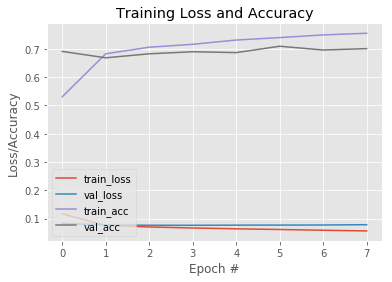

In [0]:
plot_training(history, len(history.history["loss"]))

In [0]:
(loss, categorical_accuracy) = get_metrics(cnn_model, (test_features, y_test_binarized))
print(loss)
print(categorical_accuracy)

loss: 0.07957282459546244
categorical_accuracy: 0.6762006878852844


## Inference

In [0]:
def generate_predictions(model:tf.keras.models.Sequential, article_title: str) -> list:
    labels = []
    
    title = np.array([article_title])
    cleaned_title = clean_title(title)
    tokenized = get_features(cleaned_title)
    
    probabilities = model.predict(tokenized)
    
    probabilities = probabilities.reshape(32,)
    idxs = np.argsort(probabilities)[::-1][:2]
    
    for (i, j) in enumerate(idxs):
        label = "{}: {:.2f}%".format(mlb.classes_[j], probabilities[j] * 100)
        labels.append(label)
        
    return (labels)

In [0]:
print(generate_predictions(cnn_model, 'Towards Wide Learning: Experiments in Healthcare'))

['cs.LG: 95.27%', 'stat.ML: 64.20%']


## Verification

The paper **Towards Wide Learning: Experiments in Healthcare** can be found here: https://arxiv.org/abs/1612.05730. Here are the subjects to which it got tagged:

![](https://i.ibb.co/ZLqPr2j/Screen-Shot-2019-09-27-at-12-58-16-PM.png)

## GRU

In [0]:
gru_model = get_a_sequential_model(sequential_layer=GRU, bidirectional=False)
(history, time_message) = train_model(gru_model, callbacks=callbacks)
print(time_message)

Train on 23536 samples, validate on 2616 samples
Epoch 1/10
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
23536/23536 [==============================] - 376s 16ms/sample - loss: 0.2343 - categorical_accuracy: 0.2928 - val_loss: 0.1319 - val_categorical_accuracy: 0.3505
Epoch 2/10
23536/23536 [==============================] - 372s 16ms/sample - loss: 0.1242 - categorical_accuracy: 0.3509 - val_loss: 0.1246 - val_categorical_accuracy: 0.3505
Epoch 3/10
23536/23536 [==============================] - 376s 16ms/sample - loss: 0.1209 - categorical_accuracy: 0.3509 - val_loss: 0.1236 - val_categorical_accuracy: 0.3505
Epoch 4/10
23536/23536 [==============================] - 375s 16ms/sample - loss: 0.1203 - categorical_accuracy: 0.3509 - val_loss: 0.1234 - val_categorical_accuracy: 0.3505
Epoch 5/10
23536/23536 [==============================] - 374s 16ms/sample - loss: 0.1201 - categorical_accuracy: 0.3509 - val_loss: 0.1234 - val_categorical

In [0]:
(loss, categorical_accuracy) = get_metrics(gru_model, (test_features, y_test_binarized))
print(loss)
print(categorical_accuracy)

loss: 0.1013467522225784
categorical_accuracy: 0.600336492061615


In [0]:
print(generate_predictions(gru_model, 'Towards Wide Learning: Experiments in Healthcare'))

['cs.AI: 44.43%', 'cs.LG: 36.45%']


## Visualization of the embeddings (learned by the CNN-based model)

In [0]:
word_index = tokenizer.word_index
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

In [0]:
def serialize_embeddings(model:tf.keras.models.Sequential) -> str:
    # Get the weights of the first layer (Embedding layer)
    e = model.layers[0]
    weights = e.get_weights()[0]
    # Serialize the weights in .tsv format
    out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
    out_m = io.open('meta.tsv', 'w', encoding='utf-8')
    for word_num in range(1, config.max_words):
        word = reverse_word_index[word_num]
        embeddings = weights[word_num]
        out_m.write(word + "\n")
        out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
    out_v.close()
    out_m.close()
    return 'Embeddings have been serialized'

In [0]:
print(serialize_embeddings(cnn_model))

Here's a screencast of the projection of the Embedding matrix: https://www.loom.com/share/88eaf892c02a4ba392b00ff376686e0d